In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# Training Classifiers that are Universally Robust to All Label Noise Levels

##### Xu J., Quek T. Q. S., Chong K. F. E.; arXiv:2105.13892. – 2021; https://github.com/Xu-Jingyi/PUDistill
##### Presented by Bogdan Kirillov
##### https://github.com/bakirillov/skoltech-pas2021

What should be covered in presentation:
1. Exact problem statement
2. The brief idea of the methods studied
3. Experiment setup and results
4. What was done by the team 
5. Conclusions

## Exact problem statement

1. Given a data X and noizy labels y, train an accurate classifier;
2. No assumption about noize should be used;
3. A subset of X,y pairs is known to be noizeless.

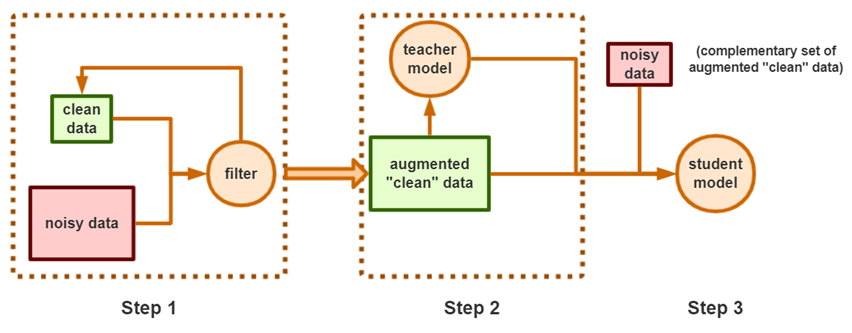

In [2]:
Image("./PUDistill/flow.png")

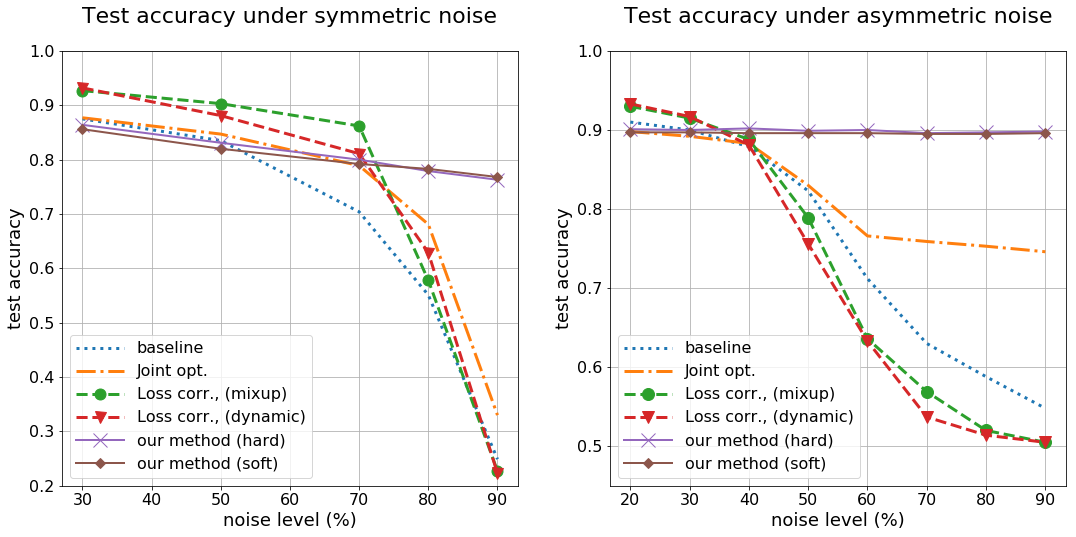

In [3]:
Image("./PUDistill/cifar.png")

## Experiment setup

1. Application of analysis towards a new dataset and a new model class (Gaussian processes);
2. Does the PUDistill procedure improve performance on a hold-out set?

## Dataset

https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

In [4]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [5]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
np.unique(df["DEATH_EVENT"], return_counts=True)

(array([0, 1]), array([203,  96]))

In [7]:
np.random.seed(1010)
from sklearn.model_selection import train_test_split
train_ix, test_ix = train_test_split(np.arange(df.values.shape[0]), stratify=df["DEATH_EVENT"])
train_ix.shape, test_ix.shape

((224,), (75,))

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
numerical = [
    "age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"
]
oh = OneHotEncoder()
ss = StandardScaler()
cats = oh.fit_transform(df[categorical].values[train_ix]).todense()
nums = ss.fit_transform(df[numerical].values[train_ix])
X = np.concatenate([cats, nums], 1)
y = df["DEATH_EVENT"].values[train_ix]
cats_test = oh.transform(df[categorical].values[test_ix]).todense()
nums_test = ss.transform(df[numerical].values[test_ix])
X_test = np.concatenate([cats_test, nums_test], 1)
y_test = df["DEATH_EVENT"].values[test_ix]

## A simple model

In [9]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import balanced_accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
simple_model = GaussianProcessClassifier(1.0 * RBF(1.0))
simple_model.fit(X, y)
y_test_hat = simple_model.predict(X_test)
balanced_accuracy_score(y_pred=y_test_hat, y_true=y_test)

0.7316176470588235

## Generating clean set

In [10]:
noizy_ix, clean_ix = train_test_split(np.arange(train_ix.shape[0]), stratify=y, test_size=0.1)
noizy_ix.shape, clean_ix.shape

((201,), (23,))

### Adding noize to the labels (to test the approach)

In [11]:
level = 0.1
for i in noizy_ix:
    change = np.random.choice([True, False], p=[1-level, level])
    if change:
        y[i] = int(not(y[i]))
    #    for b in np.arange(X[i].shape[0]):
     #       change_again = np.random.choice([True, False], p=[1-level, level])
      #      if change_again:
       #         if X[i,b] == 0 or X[i,b] == 1:
        #            X[i,b] = int(not(X[i,b]))
         #       else:
          #          X[i,b] += np.random.normal(loc=0, scale=level)

## Settings

In [12]:
K = 10 #Number of iterations
N = 100 #Number of ensemble models
alpha = 0.8 #Positive threshold
theta = 10 #Reliability threshold
N_t = 5 #Number of teacher models

### Train an ensemble filter

In [13]:
positive_set = clean_ix.copy()
negative_set = noizy_ix.copy()
relabelling = {}
for label in [0,1]:
    additional_samples = []
    add = []
    for k in tqdm(range(K)):
        m_k = min(positive_set.shape[0], len(additional_samples))
        m_k = int((m_k+positive_set.shape[0])/2)
        for n in range(N):
            current_pos = np.random.choice(positive_set, m_k, replace=False)
            current_neg = np.random.choice(negative_set, m_k, replace=False)
            current_X = np.concatenate([X[current_pos], X[current_neg]], 0)
            current_y = np.array([1]*m_k+[0]*m_k)
            current_filter = GaussianProcessClassifier(1.0 * RBF(1.0))
            current_filter.fit(
                current_X, current_y
            )
            others = np.array(
                list(filter(lambda x: x not in current_neg, negative_set.tolist()))
            )
            current_add = current_filter.predict_proba(X[others]).T[1] >= alpha
            add.extend(np.arange(X.shape[0])[others][current_add])
        reliable = list(
            filter(lambda x: x[1]>=theta, list(zip(*np.unique(add, return_counts=True))))
        )
        reliable = np.array([a[0] for a in reliable])
        reliable_B = [a in reliable for a in np.arange(X.shape[0])]
        additional_samples.extend(np.arange(X.shape[0])[reliable_B])
        positive_set = np.unique(
            np.concatenate([positive_set, additional_samples]).astype(np.int32)
        )
        negative_set = np.setdiff1d(negative_set, additional_samples)
        for a in additional_samples:
            relabelling[a] = label

100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


In [14]:
positive_set.shape

(30,)

### Augment the clean set

In [15]:
X_aug = X[positive_set]
y_aug = y[positive_set]
for a in relabelling:
    if a < y_aug.shape[0]:
        y_aug[a] = relabelling[a]

## Training teacher models

In [16]:
teachers = []
for a in tqdm(np.arange(N_t)):
    teacher = GaussianProcessClassifier(1.0 * RBF(1.0))
    teacher.fit(X_aug, y_aug)
    teachers.append(teacher)

100%|██████████| 5/5 [00:00<00:00,  9.99it/s]


## Training student models

In [17]:
nu = 0.9
teacher_Ps = []
for a in tqdm(teachers):
    teacher_Ps.append(teacher.predict_proba(X))
teacher_Ps = np.stack(teacher_Ps)

100%|██████████| 5/5 [00:00<00:00, 234.40it/s]


In [23]:
y_relabel_hard = y.copy()

In [19]:
teacher_max = np.max(np.max(teacher_Ps, 0), 1)
teacher_avg = np.mean(teacher_Ps, 0)

for i,a in enumerate(zip(teacher_max, teacher_avg)):
    if a[0] > nu:
        amx = np.argmax(a[1])
        y_relabel_hard[i] = amx

In [24]:
student = GaussianProcessClassifier(1.0 * RBF(1.0))
student.fit(X, y_relabel_hard)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [27]:
X.shape

(224, 16)

## Results

In [25]:
y_test_hat_student = student.predict(X_test)
balanced_accuracy_score(y_pred=y_test_hat_student, y_true=y_test)

0.5